In [1]:
import os
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader  # ✅ fixed here
from torchvision import transforms
from tqdm import tqdm
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
import pickle
BASE_PATH = "/kaggle/input/cifar-10-and-cifar-10-c/cifar-10-python/cifar-10-batches-py"

train_data = []
train_label = []

def unpickle(file):
    with open(file ,'rb') as f:
        data_dict = pickle.load(f , encoding = 'bytes')
    return data_dict
        
for i in range(1,6):
    batch_path = os.path.join(BASE_PATH , f"data_batch_{i}" )
    batch = unpickle(batch_path)
    train_data.append(batch[b'data'])
    train_label.extend(batch[b'labels'])

X_train = np.vstack(train_data)      
y_train = np.array(train_label)     

In [3]:
test_data = []
test_label = []

test_path = os.path.join(BASE_PATH , 'test_batch')
test_batch = unpickle(test_path)
test_data.append(batch[b'data'])
test_label.extend(batch[b'labels'])

y_test = np.array(test_label)    

In [4]:
CIFAR_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR_STD  = (0.2470, 0.2435, 0.2616)

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),         
    transforms.RandomHorizontalFlip(p=0.5),        
    transforms.ColorJitter(brightness=0.1, contrast=0.1,
                           saturation=0.1, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
])

In [5]:
def cifar_flat_to_pil(img_flat):
    r = img_flat[0:1024].reshape(32,32)
    g = img_flat[1024:2048].reshape(32,32)
    b = img_flat[2048:3072].reshape(32,32)
    img = np.stack([r,g,b], axis=2).astype('uint8')
    pil_img = Image.fromarray(img).convert("RGB")
    return pil_img

In [6]:
from PIL import Image
def cifar_dataset_to_pil(flat_images):
    pil_images = []
    for img_flat in flat_images:
        pil_img = cifar_flat_to_pil(img_flat)  # pass the array directly
        pil_images.append(pil_img)
    return pil_images

train_data_flat = np.vstack(train_data)
test_data_flat = np.vstack(test_data)   

train_images = cifar_dataset_to_pil(train_data_flat)
test_images = cifar_dataset_to_pil(test_data_flat)

In [7]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import multiprocessing

class CIFAR10_dataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.has_labels = labels is not None
        print(f"\nLoading CIFAR10 Dataset... Total Len: {len(images)} | Labeled: {self.has_labels}\n{'-'*50}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if self.transform:
            img = self.transform(img)
        if self.has_labels:
            label = torch.tensor(self.labels[idx], dtype=torch.long)
            return {"img": img, "label": label}
        else:
            return {"img": img}


train_images_split, val_images, y_train_split, y_val = train_test_split(
    train_images, y_train,
    test_size=0.2,         
    random_state=42,       
    stratify=y_train        
)

In [8]:
train_dataset = CIFAR10_dataset(train_images_split, y_train_split, transform=train_transform)
val_dataset = CIFAR10_dataset(val_images, y_val, transform=test_transform)
test_dataset = CIFAR10_dataset(test_images, labels=None, transform=test_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=multiprocessing.cpu_count(),
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=multiprocessing.cpu_count(),
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=multiprocessing.cpu_count(),
    pin_memory=True,
    persistent_workers=True
)


Loading CIFAR10 Dataset... Total Len: 40000 | Labeled: True
--------------------------------------------------

Loading CIFAR10 Dataset... Total Len: 10000 | Labeled: True
--------------------------------------------------

Loading CIFAR10 Dataset... Total Len: 10000 | Labeled: False
--------------------------------------------------


In [9]:
def create_model(model_name, num_classes=10):
    if model_name == 'ResNet18':
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'EfficientNet-B0':
        model = models.efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif model_name == 'VGG16':
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(4096, num_classes)
    
    return model

In [10]:
model_configs = {
    'ResNet18': {'optimizer': 'SGD', 'lr': 0.01, 'momentum': 0.9},
    'EfficientNet-B0': {'optimizer': 'Adam', 'lr': 0.001},
    'VGG16': {'optimizer': 'Adam', 'lr': 0.001}}

In [11]:
import os

# Create results directory
os.makedirs('/kaggle/working/model_results', exist_ok=True)

# ==================== MODEL DEFINITIONS ====================
def create_model(model_name, num_classes=10):
    if model_name == 'ResNet18':
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'EfficientNet-B0':
        model = models.efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif model_name == 'VGG16':
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(4096, num_classes)
    
    return model

# Models to train
model_configs = {
    'ResNet18': {'optimizer': 'SGD', 'lr': 0.01, 'momentum': 0.9},
    'EfficientNet-B0': {'optimizer': 'Adam', 'lr': 0.001},
    'VGG16': {'optimizer': 'Adam', 'lr': 0.0005}
}

# ==================== TRAINING FUNCTION ====================
def train_model(model, model_name, train_loader, val_loader, epochs=50):
    print(f"Training {model_name}")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    config = model_configs[model_name]
    if config['optimizer'] == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], 
                                  weight_decay=1e-4, momentum=config.get('momentum', 0.9))
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], 
                                   weight_decay=1e-4, betas=(0.9, 0.999))
    
    criterion = nn.CrossEntropyLoss()
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10, min_lr=0.00001)
    
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'val_precision': [], 'val_recall': [], 'val_f1': []
    }
    
    best_val_acc = 0
    best_model_path = f"/kaggle/working/model_results/best_{model_name.replace('-', '_')}.pth"
    
    for epoch in range(epochs):
        
        model.train()
        train_loss, train_correct = 0, 0
        all_train_preds, all_train_labels = [], []
        
        for batch in tqdm(train_loader, desc=f'{model_name} - Epoch {epoch+1}/{epochs} [Train]'):
            images, labels = batch["img"].to(device), batch["label"].to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            preds = outputs.argmax(1)
            train_correct += (preds == labels).sum().item()
            
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())
        
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = 100. * train_correct / len(train_loader.dataset)
        
        # Validation
        model.eval()
        val_loss, val_correct = 0, 0
        all_val_preds, all_val_labels, all_val_probs = [], [], []
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f'{model_name} - Epoch {epoch+1}/{epochs} [Val]'):
                images, labels = batch["img"].to(device), batch["label"].to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * images.size(0)
                preds = outputs.argmax(1)
                val_correct += (preds == labels).sum().item()
                
                probs = torch.softmax(outputs, dim=1)
                
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())
                all_val_probs.extend(probs.cpu().numpy())
        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = 100. * val_correct / len(val_loader.dataset)
        
        # Compute metrics
        from sklearn.metrics import precision_score, recall_score, f1_score
        
        val_precision = precision_score(all_val_labels, all_val_preds, average='macro', zero_division=0)
        val_recall = recall_score(all_val_labels, all_val_preds, average='macro', zero_division=0)
        val_f1 = f1_score(all_val_labels, all_val_preds, average='macro', zero_division=0)
        
        # Store history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)
        
        print(f"\n{model_name} - Epoch {epoch+1} Results:")
        print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"   Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        print(f"   Val Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1: {val_f1:.4f}")
        print(f"   LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"NEW BEST MODEL! Val Acc: {val_acc:.2f}%")
            
            # Create model-specific directory
            model_dir = f"/kaggle/working/model_results/{model_name}"
            os.makedirs(model_dir, exist_ok=True)
            
            # Save classification report
            class_names = ['airplane', 'auto', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
            report = classification_report(all_val_labels, all_val_preds, target_names=class_names, output_dict=True)
            report_df = pd.DataFrame(report).transpose()
            report_df.to_csv(f'{model_dir}/{model_name}_classification_report.csv')
            
            # Save confusion matrix
            cm = confusion_matrix(all_val_labels, all_val_preds)
            np.savetxt(f'{model_dir}/{model_name}_confusion_matrix.csv', cm, delimiter=',', fmt='%d')
            
            # Save training plots for this model
            plt.figure(figsize=(15, 5))
            
            plt.subplot(1, 3, 1)
            plt.plot(history['train_loss'][:epoch+1], label='Train Loss', linewidth=2)
            plt.plot(history['val_loss'][:epoch+1], label='Val Loss', linewidth=2)
            plt.title(f'{model_name} - Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            plt.subplot(1, 3, 2)
            plt.plot(history['train_acc'][:epoch+1], label='Train Acc', linewidth=2)
            plt.plot(history['val_acc'][:epoch+1], label='Val Acc', linewidth=2)
            plt.title(f'{model_name} - Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy (%)')
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            plt.subplot(1, 3, 3)
            plt.plot(history['val_f1'][:epoch+1], label='Val F1', color='red', linewidth=2)
            plt.title(f'{model_name} - F1 Score')
            plt.xlabel('Epoch')
            plt.ylabel('F1 Score')
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.savefig(f'{model_dir}/{model_name}_training_plots.png', dpi=120, bbox_inches='tight')
            plt.close()
        
        lr_scheduler.step(val_loss)
    
    print(f"\n{model_name} Training Complete! Best Val Acc: {best_val_acc:.2f}%")
    
    return history, best_val_acc

# ==================== TRAIN ALL MODELS ====================
all_results = {}

for model_name in model_configs.keys():
    model = create_model(model_name)
    history, best_acc = train_model(model, model_name, train_loader, val_loader, epochs=50)
    all_results[model_name] = {
        'history': history,
        'best_val_acc': best_acc
    }
    
    # Save final training history for each model
    model_dir = f"/kaggle/working/model_results/{model_name}"
    history_df = pd.DataFrame(history)
    history_df.to_csv(f'{model_dir}/{model_name}_training_history.csv', index=False)
    print(f"{model_name} training history saved to {model_dir}")

# ==================== FINAL SUMMARY ====================
print("TRAINING COMPLETE - SUMMARY")

for model_name, result in all_results.items():
    best_acc = result['best_val_acc']
    best_f1 = max(result['history']['val_f1'])
    print(f"{model_name}:")
    print(f"   Best Validation Accuracy: {best_acc:.2f}%")
    print(f"   Best F1 Score: {best_f1:.4f}")
    print(f"   Results saved to: /kaggle/working/model_results/{model_name}/")
    print()

print("All model results saved successfully!")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 184MB/s] 


Training ResNet18


ResNet18 - Epoch 1/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 67.32it/s]



ResNet18 - Epoch 1 Results:
   Train Loss: 1.3491 | Train Acc: 52.80%
   Val Loss: 0.9621 | Val Acc: 66.75%
   Val Precision: 0.6980 | Recall: 0.6675 | F1: 0.6688
   LR: 0.010000
NEW BEST MODEL! Val Acc: 66.75%


ResNet18 - Epoch 2/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 83.19it/s]



ResNet18 - Epoch 2 Results:
   Train Loss: 0.9877 | Train Acc: 65.81%
   Val Loss: 0.7849 | Val Acc: 73.24%
   Val Precision: 0.7444 | Recall: 0.7324 | F1: 0.7339
   LR: 0.010000
NEW BEST MODEL! Val Acc: 73.24%


ResNet18 - Epoch 3/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 81.94it/s]



ResNet18 - Epoch 3 Results:
   Train Loss: 0.8937 | Train Acc: 69.09%
   Val Loss: 0.7057 | Val Acc: 75.46%
   Val Precision: 0.7613 | Recall: 0.7546 | F1: 0.7501
   LR: 0.010000
NEW BEST MODEL! Val Acc: 75.46%


ResNet18 - Epoch 4/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 81.10it/s]



ResNet18 - Epoch 4 Results:
   Train Loss: 0.8203 | Train Acc: 71.64%
   Val Loss: 0.6610 | Val Acc: 77.18%
   Val Precision: 0.7767 | Recall: 0.7718 | F1: 0.7718
   LR: 0.010000
NEW BEST MODEL! Val Acc: 77.18%


ResNet18 - Epoch 5/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 81.29it/s]



ResNet18 - Epoch 5 Results:
   Train Loss: 0.7781 | Train Acc: 73.06%
   Val Loss: 0.6374 | Val Acc: 78.11%
   Val Precision: 0.7923 | Recall: 0.7811 | F1: 0.7836
   LR: 0.010000
NEW BEST MODEL! Val Acc: 78.11%


ResNet18 - Epoch 6/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 79.85it/s]



ResNet18 - Epoch 6 Results:
   Train Loss: 0.7412 | Train Acc: 74.29%
   Val Loss: 0.6160 | Val Acc: 78.64%
   Val Precision: 0.7890 | Recall: 0.7864 | F1: 0.7833
   LR: 0.010000
NEW BEST MODEL! Val Acc: 78.64%


ResNet18 - Epoch 7/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 82.17it/s]



ResNet18 - Epoch 7 Results:
   Train Loss: 0.7024 | Train Acc: 75.56%
   Val Loss: 0.6359 | Val Acc: 77.74%
   Val Precision: 0.7909 | Recall: 0.7774 | F1: 0.7771
   LR: 0.010000


ResNet18 - Epoch 8/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 82.90it/s]



ResNet18 - Epoch 8 Results:
   Train Loss: 0.6858 | Train Acc: 76.14%
   Val Loss: 0.5863 | Val Acc: 79.97%
   Val Precision: 0.8041 | Recall: 0.7997 | F1: 0.7997
   LR: 0.010000
NEW BEST MODEL! Val Acc: 79.97%


ResNet18 - Epoch 9/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 81.19it/s]



ResNet18 - Epoch 9 Results:
   Train Loss: 0.6632 | Train Acc: 76.89%
   Val Loss: 0.5710 | Val Acc: 80.22%
   Val Precision: 0.8059 | Recall: 0.8022 | F1: 0.8016
   LR: 0.010000
NEW BEST MODEL! Val Acc: 80.22%


ResNet18 - Epoch 10/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 81.43it/s]



ResNet18 - Epoch 10 Results:
   Train Loss: 0.6415 | Train Acc: 77.75%
   Val Loss: 0.5796 | Val Acc: 79.78%
   Val Precision: 0.8047 | Recall: 0.7978 | F1: 0.7937
   LR: 0.010000


ResNet18 - Epoch 11/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 83.21it/s]



ResNet18 - Epoch 11 Results:
   Train Loss: 0.6516 | Train Acc: 77.42%
   Val Loss: 0.5946 | Val Acc: 79.40%
   Val Precision: 0.8055 | Recall: 0.7940 | F1: 0.7942
   LR: 0.010000


ResNet18 - Epoch 12/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 81.52it/s]



ResNet18 - Epoch 12 Results:
   Train Loss: 0.6097 | Train Acc: 78.77%
   Val Loss: 0.5538 | Val Acc: 81.10%
   Val Precision: 0.8141 | Recall: 0.8110 | F1: 0.8094
   LR: 0.010000
NEW BEST MODEL! Val Acc: 81.10%


ResNet18 - Epoch 13/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 81.48it/s]



ResNet18 - Epoch 13 Results:
   Train Loss: 0.5900 | Train Acc: 79.29%
   Val Loss: 0.5738 | Val Acc: 80.85%
   Val Precision: 0.8156 | Recall: 0.8085 | F1: 0.8086
   LR: 0.010000


ResNet18 - Epoch 14/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 81.00it/s]



ResNet18 - Epoch 14 Results:
   Train Loss: 0.5797 | Train Acc: 79.88%
   Val Loss: 0.5330 | Val Acc: 81.92%
   Val Precision: 0.8222 | Recall: 0.8192 | F1: 0.8195
   LR: 0.010000
NEW BEST MODEL! Val Acc: 81.92%


ResNet18 - Epoch 15/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 81.66it/s]



ResNet18 - Epoch 15 Results:
   Train Loss: 0.5568 | Train Acc: 80.53%
   Val Loss: 0.5239 | Val Acc: 81.85%
   Val Precision: 0.8231 | Recall: 0.8185 | F1: 0.8194
   LR: 0.010000


ResNet18 - Epoch 16/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 81.30it/s]



ResNet18 - Epoch 16 Results:
   Train Loss: 0.5524 | Train Acc: 80.55%
   Val Loss: 0.5539 | Val Acc: 81.48%
   Val Precision: 0.8216 | Recall: 0.8148 | F1: 0.8163
   LR: 0.010000


ResNet18 - Epoch 17/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 79.34it/s]



ResNet18 - Epoch 17 Results:
   Train Loss: 0.5530 | Train Acc: 80.71%
   Val Loss: 0.5399 | Val Acc: 81.75%
   Val Precision: 0.8268 | Recall: 0.8175 | F1: 0.8191
   LR: 0.010000


ResNet18 - Epoch 18/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 82.61it/s]



ResNet18 - Epoch 18 Results:
   Train Loss: 0.5319 | Train Acc: 81.12%
   Val Loss: 0.5311 | Val Acc: 82.15%
   Val Precision: 0.8281 | Recall: 0.8215 | F1: 0.8214
   LR: 0.010000
NEW BEST MODEL! Val Acc: 82.15%


ResNet18 - Epoch 19/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 81.21it/s]



ResNet18 - Epoch 19 Results:
   Train Loss: 0.5549 | Train Acc: 80.60%
   Val Loss: 0.6034 | Val Acc: 79.69%
   Val Precision: 0.8037 | Recall: 0.7969 | F1: 0.7973
   LR: 0.010000


ResNet18 - Epoch 20/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 80.61it/s]



ResNet18 - Epoch 20 Results:
   Train Loss: 0.5395 | Train Acc: 80.94%
   Val Loss: 0.5368 | Val Acc: 81.92%
   Val Precision: 0.8213 | Recall: 0.8192 | F1: 0.8186
   LR: 0.010000


ResNet18 - Epoch 21/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 81.94it/s]



ResNet18 - Epoch 21 Results:
   Train Loss: 0.5084 | Train Acc: 82.15%
   Val Loss: 0.5170 | Val Acc: 82.47%
   Val Precision: 0.8309 | Recall: 0.8247 | F1: 0.8262
   LR: 0.010000
NEW BEST MODEL! Val Acc: 82.47%


ResNet18 - Epoch 22/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 82.29it/s]



ResNet18 - Epoch 22 Results:
   Train Loss: 0.4990 | Train Acc: 82.51%
   Val Loss: 0.5080 | Val Acc: 82.79%
   Val Precision: 0.8277 | Recall: 0.8279 | F1: 0.8271
   LR: 0.010000
NEW BEST MODEL! Val Acc: 82.79%


ResNet18 - Epoch 23/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 80.53it/s]



ResNet18 - Epoch 23 Results:
   Train Loss: 0.4907 | Train Acc: 82.65%
   Val Loss: 0.5032 | Val Acc: 83.24%
   Val Precision: 0.8381 | Recall: 0.8324 | F1: 0.8337
   LR: 0.010000
NEW BEST MODEL! Val Acc: 83.24%


ResNet18 - Epoch 24/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 82.59it/s]



ResNet18 - Epoch 24 Results:
   Train Loss: 0.4718 | Train Acc: 83.32%
   Val Loss: 0.5339 | Val Acc: 82.09%
   Val Precision: 0.8275 | Recall: 0.8209 | F1: 0.8230
   LR: 0.010000


ResNet18 - Epoch 25/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 79.59it/s]



ResNet18 - Epoch 25 Results:
   Train Loss: 0.4692 | Train Acc: 83.45%
   Val Loss: 0.5066 | Val Acc: 82.94%
   Val Precision: 0.8325 | Recall: 0.8294 | F1: 0.8304
   LR: 0.010000


ResNet18 - Epoch 26/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 83.99it/s]



ResNet18 - Epoch 26 Results:
   Train Loss: 0.4617 | Train Acc: 83.72%
   Val Loss: 0.5037 | Val Acc: 83.40%
   Val Precision: 0.8410 | Recall: 0.8340 | F1: 0.8359
   LR: 0.010000
NEW BEST MODEL! Val Acc: 83.40%


ResNet18 - Epoch 27/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 81.66it/s]



ResNet18 - Epoch 27 Results:
   Train Loss: 0.4486 | Train Acc: 84.34%
   Val Loss: 0.5054 | Val Acc: 82.92%
   Val Precision: 0.8359 | Recall: 0.8292 | F1: 0.8311
   LR: 0.010000


ResNet18 - Epoch 28/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 81.47it/s]



ResNet18 - Epoch 28 Results:
   Train Loss: 0.4548 | Train Acc: 83.84%
   Val Loss: 0.5007 | Val Acc: 82.94%
   Val Precision: 0.8326 | Recall: 0.8294 | F1: 0.8297
   LR: 0.010000


ResNet18 - Epoch 29/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 80.97it/s]



ResNet18 - Epoch 29 Results:
   Train Loss: 0.4398 | Train Acc: 84.37%
   Val Loss: 0.5378 | Val Acc: 82.62%
   Val Precision: 0.8327 | Recall: 0.8262 | F1: 0.8264
   LR: 0.010000


ResNet18 - Epoch 30/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 80.86it/s]



ResNet18 - Epoch 30 Results:
   Train Loss: 0.4348 | Train Acc: 84.59%
   Val Loss: 0.4953 | Val Acc: 83.27%
   Val Precision: 0.8376 | Recall: 0.8327 | F1: 0.8339
   LR: 0.010000


ResNet18 - Epoch 31/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 67.43it/s]



ResNet18 - Epoch 31 Results:
   Train Loss: 0.4179 | Train Acc: 85.18%
   Val Loss: 0.5121 | Val Acc: 83.10%
   Val Precision: 0.8339 | Recall: 0.8310 | F1: 0.8311
   LR: 0.010000


ResNet18 - Epoch 32/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 80.34it/s]



ResNet18 - Epoch 32 Results:
   Train Loss: 0.4148 | Train Acc: 85.42%
   Val Loss: 0.5147 | Val Acc: 83.49%
   Val Precision: 0.8403 | Recall: 0.8349 | F1: 0.8362
   LR: 0.010000
NEW BEST MODEL! Val Acc: 83.49%


ResNet18 - Epoch 33/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 82.41it/s]



ResNet18 - Epoch 33 Results:
   Train Loss: 0.4107 | Train Acc: 85.49%
   Val Loss: 0.4991 | Val Acc: 83.54%
   Val Precision: 0.8397 | Recall: 0.8354 | F1: 0.8356
   LR: 0.010000
NEW BEST MODEL! Val Acc: 83.54%


ResNet18 - Epoch 34/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 81.93it/s]



ResNet18 - Epoch 34 Results:
   Train Loss: 0.4079 | Train Acc: 85.42%
   Val Loss: 0.4885 | Val Acc: 84.08%
   Val Precision: 0.8433 | Recall: 0.8408 | F1: 0.8401
   LR: 0.010000
NEW BEST MODEL! Val Acc: 84.08%


ResNet18 - Epoch 35/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 82.33it/s]



ResNet18 - Epoch 35 Results:
   Train Loss: 0.4040 | Train Acc: 85.74%
   Val Loss: 0.5195 | Val Acc: 83.42%
   Val Precision: 0.8382 | Recall: 0.8342 | F1: 0.8354
   LR: 0.010000


ResNet18 - Epoch 36/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 83.24it/s]



ResNet18 - Epoch 36 Results:
   Train Loss: 0.4030 | Train Acc: 85.61%
   Val Loss: 0.4894 | Val Acc: 84.36%
   Val Precision: 0.8480 | Recall: 0.8436 | F1: 0.8447
   LR: 0.010000
NEW BEST MODEL! Val Acc: 84.36%


ResNet18 - Epoch 37/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 82.33it/s]



ResNet18 - Epoch 37 Results:
   Train Loss: 0.3866 | Train Acc: 86.23%
   Val Loss: 0.5030 | Val Acc: 83.90%
   Val Precision: 0.8413 | Recall: 0.8390 | F1: 0.8394
   LR: 0.010000


ResNet18 - Epoch 38/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 82.52it/s]



ResNet18 - Epoch 38 Results:
   Train Loss: 0.3795 | Train Acc: 86.62%
   Val Loss: 0.5183 | Val Acc: 83.73%
   Val Precision: 0.8394 | Recall: 0.8373 | F1: 0.8374
   LR: 0.010000


ResNet18 - Epoch 39/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 82.16it/s]



ResNet18 - Epoch 39 Results:
   Train Loss: 0.3761 | Train Acc: 86.63%
   Val Loss: 0.5484 | Val Acc: 82.95%
   Val Precision: 0.8314 | Recall: 0.8295 | F1: 0.8291
   LR: 0.010000


ResNet18 - Epoch 40/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 80.46it/s]



ResNet18 - Epoch 40 Results:
   Train Loss: 0.3771 | Train Acc: 86.67%
   Val Loss: 0.5089 | Val Acc: 84.12%
   Val Precision: 0.8415 | Recall: 0.8412 | F1: 0.8405
   LR: 0.010000


ResNet18 - Epoch 41/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 82.46it/s]



ResNet18 - Epoch 41 Results:
   Train Loss: 0.3670 | Train Acc: 86.87%
   Val Loss: 0.5227 | Val Acc: 84.06%
   Val Precision: 0.8451 | Recall: 0.8406 | F1: 0.8419
   LR: 0.010000


ResNet18 - Epoch 42/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 82.86it/s]



ResNet18 - Epoch 42 Results:
   Train Loss: 0.3695 | Train Acc: 87.02%
   Val Loss: 0.5026 | Val Acc: 83.82%
   Val Precision: 0.8415 | Recall: 0.8382 | F1: 0.8384
   LR: 0.010000


ResNet18 - Epoch 43/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 80.91it/s]



ResNet18 - Epoch 43 Results:
   Train Loss: 0.3592 | Train Acc: 87.16%
   Val Loss: 0.5442 | Val Acc: 83.20%
   Val Precision: 0.8359 | Recall: 0.8320 | F1: 0.8323
   LR: 0.010000


ResNet18 - Epoch 44/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 82.57it/s]



ResNet18 - Epoch 44 Results:
   Train Loss: 0.3535 | Train Acc: 87.48%
   Val Loss: 0.5160 | Val Acc: 84.07%
   Val Precision: 0.8435 | Recall: 0.8407 | F1: 0.8414
   LR: 0.010000


ResNet18 - Epoch 45/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 78.42it/s]



ResNet18 - Epoch 45 Results:
   Train Loss: 0.3462 | Train Acc: 87.56%
   Val Loss: 0.5129 | Val Acc: 84.00%
   Val Precision: 0.8408 | Recall: 0.8400 | F1: 0.8397
   LR: 0.010000


ResNet18 - Epoch 46/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 82.28it/s]



ResNet18 - Epoch 46 Results:
   Train Loss: 0.2842 | Train Acc: 89.86%
   Val Loss: 0.4766 | Val Acc: 85.07%
   Val Precision: 0.8534 | Recall: 0.8507 | F1: 0.8514
   LR: 0.001000
NEW BEST MODEL! Val Acc: 85.07%


ResNet18 - Epoch 47/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 81.22it/s]



ResNet18 - Epoch 47 Results:
   Train Loss: 0.2537 | Train Acc: 91.09%
   Val Loss: 0.4707 | Val Acc: 85.62%
   Val Precision: 0.8583 | Recall: 0.8562 | F1: 0.8569
   LR: 0.001000
NEW BEST MODEL! Val Acc: 85.62%


ResNet18 - Epoch 48/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 79.93it/s]



ResNet18 - Epoch 48 Results:
   Train Loss: 0.2465 | Train Acc: 91.30%
   Val Loss: 0.4821 | Val Acc: 85.36%
   Val Precision: 0.8564 | Recall: 0.8536 | F1: 0.8546
   LR: 0.001000


ResNet18 - Epoch 49/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 79.85it/s]



ResNet18 - Epoch 49 Results:
   Train Loss: 0.2322 | Train Acc: 91.74%
   Val Loss: 0.4791 | Val Acc: 85.84%
   Val Precision: 0.8602 | Recall: 0.8584 | F1: 0.8590
   LR: 0.001000
NEW BEST MODEL! Val Acc: 85.84%


ResNet18 - Epoch 50/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 80.70it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



ResNet18 - Epoch 50 Results:
   Train Loss: 0.2207 | Train Acc: 92.11%
   Val Loss: 0.4882 | Val Acc: 85.76%
   Val Precision: 0.8599 | Recall: 0.8576 | F1: 0.8584
   LR: 0.001000

ResNet18 Training Complete! Best Val Acc: 85.84%
ResNet18 training history saved to /kaggle/working/model_results/ResNet18


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 142MB/s]


Training EfficientNet-B0


EfficientNet-B0 - Epoch 1/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 60.26it/s]



EfficientNet-B0 - Epoch 1 Results:
   Train Loss: 1.3909 | Train Acc: 50.92%
   Val Loss: 0.9308 | Val Acc: 67.51%
   Val Precision: 0.6758 | Recall: 0.6751 | F1: 0.6700
   LR: 0.001000
NEW BEST MODEL! Val Acc: 67.51%


EfficientNet-B0 - Epoch 2/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 59.33it/s]



EfficientNet-B0 - Epoch 2 Results:
   Train Loss: 0.9755 | Train Acc: 66.53%
   Val Loss: 0.7042 | Val Acc: 75.48%
   Val Precision: 0.7584 | Recall: 0.7548 | F1: 0.7549
   LR: 0.001000
NEW BEST MODEL! Val Acc: 75.48%


EfficientNet-B0 - Epoch 3/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 61.48it/s]



EfficientNet-B0 - Epoch 3 Results:
   Train Loss: 0.8385 | Train Acc: 70.98%
   Val Loss: 0.6533 | Val Acc: 77.51%
   Val Precision: 0.7829 | Recall: 0.7751 | F1: 0.7763
   LR: 0.001000
NEW BEST MODEL! Val Acc: 77.51%


EfficientNet-B0 - Epoch 4/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 60.22it/s]



EfficientNet-B0 - Epoch 4 Results:
   Train Loss: 0.7674 | Train Acc: 73.28%
   Val Loss: 0.5849 | Val Acc: 79.66%
   Val Precision: 0.8015 | Recall: 0.7966 | F1: 0.7953
   LR: 0.001000
NEW BEST MODEL! Val Acc: 79.66%


EfficientNet-B0 - Epoch 5/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 59.13it/s]



EfficientNet-B0 - Epoch 5 Results:
   Train Loss: 0.7139 | Train Acc: 75.37%
   Val Loss: 0.5577 | Val Acc: 80.95%
   Val Precision: 0.8117 | Recall: 0.8095 | F1: 0.8091
   LR: 0.001000
NEW BEST MODEL! Val Acc: 80.95%


EfficientNet-B0 - Epoch 6/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 56.93it/s]



EfficientNet-B0 - Epoch 6 Results:
   Train Loss: 0.6857 | Train Acc: 76.16%
   Val Loss: 0.5400 | Val Acc: 82.02%
   Val Precision: 0.8236 | Recall: 0.8202 | F1: 0.8206
   LR: 0.001000
NEW BEST MODEL! Val Acc: 82.02%


EfficientNet-B0 - Epoch 7/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 62.55it/s]



EfficientNet-B0 - Epoch 7 Results:
   Train Loss: 0.6470 | Train Acc: 77.59%
   Val Loss: 0.5101 | Val Acc: 82.31%
   Val Precision: 0.8280 | Recall: 0.8231 | F1: 0.8241
   LR: 0.001000
NEW BEST MODEL! Val Acc: 82.31%


EfficientNet-B0 - Epoch 8/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 61.27it/s]



EfficientNet-B0 - Epoch 8 Results:
   Train Loss: 0.6233 | Train Acc: 78.21%
   Val Loss: 0.4917 | Val Acc: 82.83%
   Val Precision: 0.8307 | Recall: 0.8283 | F1: 0.8285
   LR: 0.001000
NEW BEST MODEL! Val Acc: 82.83%


EfficientNet-B0 - Epoch 9/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 61.46it/s]



EfficientNet-B0 - Epoch 9 Results:
   Train Loss: 0.6058 | Train Acc: 79.15%
   Val Loss: 0.5246 | Val Acc: 81.93%
   Val Precision: 0.8262 | Recall: 0.8193 | F1: 0.8189
   LR: 0.001000


EfficientNet-B0 - Epoch 10/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 62.09it/s]



EfficientNet-B0 - Epoch 10 Results:
   Train Loss: 0.5961 | Train Acc: 79.28%
   Val Loss: 0.5015 | Val Acc: 83.18%
   Val Precision: 0.8333 | Recall: 0.8318 | F1: 0.8313
   LR: 0.001000
NEW BEST MODEL! Val Acc: 83.18%


EfficientNet-B0 - Epoch 11/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 59.83it/s]



EfficientNet-B0 - Epoch 11 Results:
   Train Loss: 0.5715 | Train Acc: 80.31%
   Val Loss: 0.5219 | Val Acc: 82.67%
   Val Precision: 0.8366 | Recall: 0.8267 | F1: 0.8246
   LR: 0.001000


EfficientNet-B0 - Epoch 12/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 56.91it/s]



EfficientNet-B0 - Epoch 12 Results:
   Train Loss: 0.5629 | Train Acc: 80.49%
   Val Loss: 0.4880 | Val Acc: 83.67%
   Val Precision: 0.8428 | Recall: 0.8367 | F1: 0.8376
   LR: 0.001000
NEW BEST MODEL! Val Acc: 83.67%


EfficientNet-B0 - Epoch 13/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 61.28it/s]



EfficientNet-B0 - Epoch 13 Results:
   Train Loss: 0.5455 | Train Acc: 80.86%
   Val Loss: 0.4777 | Val Acc: 83.78%
   Val Precision: 0.8434 | Recall: 0.8378 | F1: 0.8388
   LR: 0.001000
NEW BEST MODEL! Val Acc: 83.78%


EfficientNet-B0 - Epoch 14/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 61.07it/s]



EfficientNet-B0 - Epoch 14 Results:
   Train Loss: 0.5378 | Train Acc: 81.40%
   Val Loss: 0.4602 | Val Acc: 84.25%
   Val Precision: 0.8439 | Recall: 0.8425 | F1: 0.8425
   LR: 0.001000
NEW BEST MODEL! Val Acc: 84.25%


EfficientNet-B0 - Epoch 15/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 60.69it/s]



EfficientNet-B0 - Epoch 15 Results:
   Train Loss: 0.5311 | Train Acc: 81.39%
   Val Loss: 0.4490 | Val Acc: 84.55%
   Val Precision: 0.8485 | Recall: 0.8455 | F1: 0.8454
   LR: 0.001000
NEW BEST MODEL! Val Acc: 84.55%


EfficientNet-B0 - Epoch 16/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 60.79it/s]



EfficientNet-B0 - Epoch 16 Results:
   Train Loss: 0.5188 | Train Acc: 81.78%
   Val Loss: 0.4599 | Val Acc: 84.10%
   Val Precision: 0.8437 | Recall: 0.8410 | F1: 0.8411
   LR: 0.001000


EfficientNet-B0 - Epoch 17/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 61.04it/s]



EfficientNet-B0 - Epoch 17 Results:
   Train Loss: 0.5121 | Train Acc: 82.41%
   Val Loss: 0.4414 | Val Acc: 85.10%
   Val Precision: 0.8553 | Recall: 0.8510 | F1: 0.8514
   LR: 0.001000
NEW BEST MODEL! Val Acc: 85.10%


EfficientNet-B0 - Epoch 18/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 59.65it/s]



EfficientNet-B0 - Epoch 18 Results:
   Train Loss: 0.5021 | Train Acc: 82.57%
   Val Loss: 0.4256 | Val Acc: 85.29%
   Val Precision: 0.8538 | Recall: 0.8529 | F1: 0.8529
   LR: 0.001000
NEW BEST MODEL! Val Acc: 85.29%


EfficientNet-B0 - Epoch 19/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 59.99it/s]



EfficientNet-B0 - Epoch 19 Results:
   Train Loss: 0.4976 | Train Acc: 82.53%
   Val Loss: 0.4511 | Val Acc: 84.58%
   Val Precision: 0.8519 | Recall: 0.8458 | F1: 0.8469
   LR: 0.001000


EfficientNet-B0 - Epoch 20/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 59.52it/s]



EfficientNet-B0 - Epoch 20 Results:
   Train Loss: 0.4872 | Train Acc: 83.11%
   Val Loss: 0.4305 | Val Acc: 85.48%
   Val Precision: 0.8569 | Recall: 0.8548 | F1: 0.8542
   LR: 0.001000
NEW BEST MODEL! Val Acc: 85.48%


EfficientNet-B0 - Epoch 21/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 60.98it/s]



EfficientNet-B0 - Epoch 21 Results:
   Train Loss: 0.4753 | Train Acc: 83.34%
   Val Loss: 0.4462 | Val Acc: 84.60%
   Val Precision: 0.8519 | Recall: 0.8460 | F1: 0.8472
   LR: 0.001000


EfficientNet-B0 - Epoch 22/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 61.14it/s]



EfficientNet-B0 - Epoch 22 Results:
   Train Loss: 0.4759 | Train Acc: 83.53%
   Val Loss: 0.4160 | Val Acc: 86.16%
   Val Precision: 0.8639 | Recall: 0.8616 | F1: 0.8622
   LR: 0.001000
NEW BEST MODEL! Val Acc: 86.16%


EfficientNet-B0 - Epoch 23/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 61.74it/s]



EfficientNet-B0 - Epoch 23 Results:
   Train Loss: 0.4719 | Train Acc: 83.52%
   Val Loss: 0.4356 | Val Acc: 85.37%
   Val Precision: 0.8595 | Recall: 0.8537 | F1: 0.8550
   LR: 0.001000


EfficientNet-B0 - Epoch 24/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 59.69it/s]



EfficientNet-B0 - Epoch 24 Results:
   Train Loss: 0.4556 | Train Acc: 84.23%
   Val Loss: 0.4343 | Val Acc: 85.17%
   Val Precision: 0.8541 | Recall: 0.8517 | F1: 0.8503
   LR: 0.001000


EfficientNet-B0 - Epoch 25/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 60.84it/s]



EfficientNet-B0 - Epoch 25 Results:
   Train Loss: 0.4551 | Train Acc: 84.08%
   Val Loss: 0.4307 | Val Acc: 85.12%
   Val Precision: 0.8525 | Recall: 0.8512 | F1: 0.8509
   LR: 0.001000


EfficientNet-B0 - Epoch 26/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 60.94it/s]



EfficientNet-B0 - Epoch 26 Results:
   Train Loss: 0.4461 | Train Acc: 84.52%
   Val Loss: 0.4211 | Val Acc: 85.73%
   Val Precision: 0.8576 | Recall: 0.8573 | F1: 0.8569
   LR: 0.001000


EfficientNet-B0 - Epoch 27/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 55.52it/s]



EfficientNet-B0 - Epoch 27 Results:
   Train Loss: 0.4517 | Train Acc: 84.21%
   Val Loss: 0.4365 | Val Acc: 85.37%
   Val Precision: 0.8571 | Recall: 0.8537 | F1: 0.8535
   LR: 0.001000


EfficientNet-B0 - Epoch 28/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 62.17it/s]



EfficientNet-B0 - Epoch 28 Results:
   Train Loss: 0.4411 | Train Acc: 84.44%
   Val Loss: 0.4191 | Val Acc: 85.94%
   Val Precision: 0.8616 | Recall: 0.8594 | F1: 0.8594
   LR: 0.001000


EfficientNet-B0 - Epoch 29/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 59.94it/s]



EfficientNet-B0 - Epoch 29 Results:
   Train Loss: 0.4334 | Train Acc: 84.68%
   Val Loss: 0.4387 | Val Acc: 85.50%
   Val Precision: 0.8594 | Recall: 0.8550 | F1: 0.8558
   LR: 0.001000


EfficientNet-B0 - Epoch 30/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 59.47it/s]



EfficientNet-B0 - Epoch 30 Results:
   Train Loss: 0.4329 | Train Acc: 84.80%
   Val Loss: 0.4291 | Val Acc: 85.55%
   Val Precision: 0.8578 | Recall: 0.8555 | F1: 0.8560
   LR: 0.001000


EfficientNet-B0 - Epoch 31/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 60.03it/s]



EfficientNet-B0 - Epoch 31 Results:
   Train Loss: 0.4295 | Train Acc: 85.08%
   Val Loss: 0.4192 | Val Acc: 85.92%
   Val Precision: 0.8597 | Recall: 0.8592 | F1: 0.8588
   LR: 0.001000


EfficientNet-B0 - Epoch 32/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 60.45it/s]



EfficientNet-B0 - Epoch 32 Results:
   Train Loss: 0.4228 | Train Acc: 85.10%
   Val Loss: 0.4298 | Val Acc: 85.58%
   Val Precision: 0.8602 | Recall: 0.8558 | F1: 0.8554
   LR: 0.001000


EfficientNet-B0 - Epoch 33/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 61.63it/s]



EfficientNet-B0 - Epoch 33 Results:
   Train Loss: 0.4173 | Train Acc: 85.39%
   Val Loss: 0.4120 | Val Acc: 86.08%
   Val Precision: 0.8645 | Recall: 0.8608 | F1: 0.8617
   LR: 0.001000


EfficientNet-B0 - Epoch 34/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 60.12it/s]



EfficientNet-B0 - Epoch 34 Results:
   Train Loss: 0.4187 | Train Acc: 85.41%
   Val Loss: 0.4098 | Val Acc: 85.86%
   Val Precision: 0.8640 | Recall: 0.8586 | F1: 0.8590
   LR: 0.001000


EfficientNet-B0 - Epoch 35/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 61.89it/s]



EfficientNet-B0 - Epoch 35 Results:
   Train Loss: 0.4106 | Train Acc: 85.59%
   Val Loss: 0.4181 | Val Acc: 86.28%
   Val Precision: 0.8659 | Recall: 0.8628 | F1: 0.8634
   LR: 0.001000
NEW BEST MODEL! Val Acc: 86.28%


EfficientNet-B0 - Epoch 36/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 61.88it/s]



EfficientNet-B0 - Epoch 36 Results:
   Train Loss: 0.3994 | Train Acc: 86.05%
   Val Loss: 0.4197 | Val Acc: 85.90%
   Val Precision: 0.8627 | Recall: 0.8590 | F1: 0.8599
   LR: 0.001000


EfficientNet-B0 - Epoch 37/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 61.00it/s]



EfficientNet-B0 - Epoch 37 Results:
   Train Loss: 0.4000 | Train Acc: 85.86%
   Val Loss: 0.4155 | Val Acc: 86.44%
   Val Precision: 0.8682 | Recall: 0.8644 | F1: 0.8649
   LR: 0.001000
NEW BEST MODEL! Val Acc: 86.44%


EfficientNet-B0 - Epoch 38/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 59.39it/s]



EfficientNet-B0 - Epoch 38 Results:
   Train Loss: 0.4038 | Train Acc: 85.91%
   Val Loss: 0.4265 | Val Acc: 85.68%
   Val Precision: 0.8587 | Recall: 0.8568 | F1: 0.8571
   LR: 0.001000


EfficientNet-B0 - Epoch 39/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 61.38it/s]



EfficientNet-B0 - Epoch 39 Results:
   Train Loss: 0.3944 | Train Acc: 86.03%
   Val Loss: 0.4245 | Val Acc: 85.63%
   Val Precision: 0.8602 | Recall: 0.8563 | F1: 0.8572
   LR: 0.001000


EfficientNet-B0 - Epoch 40/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 60.62it/s]



EfficientNet-B0 - Epoch 40 Results:
   Train Loss: 0.3870 | Train Acc: 86.50%
   Val Loss: 0.4075 | Val Acc: 86.36%
   Val Precision: 0.8659 | Recall: 0.8636 | F1: 0.8637
   LR: 0.001000


EfficientNet-B0 - Epoch 41/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 61.74it/s]



EfficientNet-B0 - Epoch 41 Results:
   Train Loss: 0.3944 | Train Acc: 86.13%
   Val Loss: 0.4101 | Val Acc: 86.41%
   Val Precision: 0.8685 | Recall: 0.8641 | F1: 0.8653
   LR: 0.001000


EfficientNet-B0 - Epoch 42/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 60.14it/s]



EfficientNet-B0 - Epoch 42 Results:
   Train Loss: 0.3843 | Train Acc: 86.39%
   Val Loss: 0.4259 | Val Acc: 85.70%
   Val Precision: 0.8648 | Recall: 0.8570 | F1: 0.8574
   LR: 0.001000


EfficientNet-B0 - Epoch 43/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 59.92it/s]



EfficientNet-B0 - Epoch 43 Results:
   Train Loss: 0.3822 | Train Acc: 86.73%
   Val Loss: 0.4185 | Val Acc: 86.19%
   Val Precision: 0.8639 | Recall: 0.8619 | F1: 0.8625
   LR: 0.001000


EfficientNet-B0 - Epoch 44/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 59.27it/s]



EfficientNet-B0 - Epoch 44 Results:
   Train Loss: 0.3773 | Train Acc: 86.69%
   Val Loss: 0.4118 | Val Acc: 86.12%
   Val Precision: 0.8629 | Recall: 0.8612 | F1: 0.8607
   LR: 0.001000


EfficientNet-B0 - Epoch 45/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 58.98it/s]



EfficientNet-B0 - Epoch 45 Results:
   Train Loss: 0.3815 | Train Acc: 86.61%
   Val Loss: 0.4112 | Val Acc: 86.30%
   Val Precision: 0.8630 | Recall: 0.8630 | F1: 0.8628
   LR: 0.001000


EfficientNet-B0 - Epoch 46/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 61.39it/s]



EfficientNet-B0 - Epoch 46 Results:
   Train Loss: 0.3778 | Train Acc: 86.52%
   Val Loss: 0.3989 | Val Acc: 86.74%
   Val Precision: 0.8695 | Recall: 0.8674 | F1: 0.8678
   LR: 0.001000
NEW BEST MODEL! Val Acc: 86.74%


EfficientNet-B0 - Epoch 47/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 61.28it/s]



EfficientNet-B0 - Epoch 47 Results:
   Train Loss: 0.3714 | Train Acc: 87.00%
   Val Loss: 0.4199 | Val Acc: 86.07%
   Val Precision: 0.8624 | Recall: 0.8607 | F1: 0.8605
   LR: 0.001000


EfficientNet-B0 - Epoch 48/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 60.38it/s]



EfficientNet-B0 - Epoch 48 Results:
   Train Loss: 0.3666 | Train Acc: 87.17%
   Val Loss: 0.4104 | Val Acc: 86.27%
   Val Precision: 0.8655 | Recall: 0.8627 | F1: 0.8634
   LR: 0.001000


EfficientNet-B0 - Epoch 49/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 59.99it/s]



EfficientNet-B0 - Epoch 49 Results:
   Train Loss: 0.3617 | Train Acc: 87.31%
   Val Loss: 0.4279 | Val Acc: 85.80%
   Val Precision: 0.8612 | Recall: 0.8580 | F1: 0.8586
   LR: 0.001000


EfficientNet-B0 - Epoch 50/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 59.84it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



EfficientNet-B0 - Epoch 50 Results:
   Train Loss: 0.3672 | Train Acc: 86.97%
   Val Loss: 0.4323 | Val Acc: 85.27%
   Val Precision: 0.8585 | Recall: 0.8527 | F1: 0.8538
   LR: 0.001000

EfficientNet-B0 Training Complete! Best Val Acc: 86.74%
EfficientNet-B0 training history saved to /kaggle/working/model_results/EfficientNet-B0


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 211MB/s] 


Training VGG16


VGG16 - Epoch 1/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.13it/s]



VGG16 - Epoch 1 Results:
   Train Loss: 1.4409 | Train Acc: 47.29%
   Val Loss: 0.8080 | Val Acc: 73.20%
   Val Precision: 0.7459 | Recall: 0.7320 | F1: 0.7317
   LR: 0.000500
NEW BEST MODEL! Val Acc: 73.20%


VGG16 - Epoch 2/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.34it/s]



VGG16 - Epoch 2 Results:
   Train Loss: 0.8995 | Train Acc: 70.33%
   Val Loss: 0.6798 | Val Acc: 78.39%
   Val Precision: 0.7907 | Recall: 0.7839 | F1: 0.7825
   LR: 0.000500
NEW BEST MODEL! Val Acc: 78.39%


VGG16 - Epoch 3/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.17it/s]



VGG16 - Epoch 3 Results:
   Train Loss: 0.7583 | Train Acc: 75.29%
   Val Loss: 0.6840 | Val Acc: 79.76%
   Val Precision: 0.8111 | Recall: 0.7976 | F1: 0.7930
   LR: 0.000500
NEW BEST MODEL! Val Acc: 79.76%


VGG16 - Epoch 4/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.16it/s]



VGG16 - Epoch 4 Results:
   Train Loss: 0.6750 | Train Acc: 78.32%
   Val Loss: 0.5178 | Val Acc: 82.31%
   Val Precision: 0.8329 | Recall: 0.8231 | F1: 0.8166
   LR: 0.000500
NEW BEST MODEL! Val Acc: 82.31%


VGG16 - Epoch 5/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.47it/s]



VGG16 - Epoch 5 Results:
   Train Loss: 0.6133 | Train Acc: 80.07%
   Val Loss: 0.4838 | Val Acc: 84.08%
   Val Precision: 0.8396 | Recall: 0.8408 | F1: 0.8390
   LR: 0.000500
NEW BEST MODEL! Val Acc: 84.08%


VGG16 - Epoch 6/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.36it/s]



VGG16 - Epoch 6 Results:
   Train Loss: 0.5917 | Train Acc: 80.89%
   Val Loss: 0.5043 | Val Acc: 84.00%
   Val Precision: 0.8487 | Recall: 0.8400 | F1: 0.8408
   LR: 0.000500


VGG16 - Epoch 7/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.31it/s]



VGG16 - Epoch 7 Results:
   Train Loss: 0.5446 | Train Acc: 82.44%
   Val Loss: 0.4572 | Val Acc: 86.08%
   Val Precision: 0.8649 | Recall: 0.8608 | F1: 0.8610
   LR: 0.000500
NEW BEST MODEL! Val Acc: 86.08%


VGG16 - Epoch 8/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.35it/s]



VGG16 - Epoch 8 Results:
   Train Loss: 0.5271 | Train Acc: 82.95%
   Val Loss: 0.4339 | Val Acc: 86.26%
   Val Precision: 0.8677 | Recall: 0.8626 | F1: 0.8633
   LR: 0.000500
NEW BEST MODEL! Val Acc: 86.26%


VGG16 - Epoch 9/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.51it/s]



VGG16 - Epoch 9 Results:
   Train Loss: 0.5056 | Train Acc: 83.82%
   Val Loss: 0.4098 | Val Acc: 86.81%
   Val Precision: 0.8730 | Recall: 0.8681 | F1: 0.8693
   LR: 0.000500
NEW BEST MODEL! Val Acc: 86.81%


VGG16 - Epoch 10/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.75it/s]



VGG16 - Epoch 10 Results:
   Train Loss: 0.4754 | Train Acc: 84.75%
   Val Loss: 0.4814 | Val Acc: 84.71%
   Val Precision: 0.8636 | Recall: 0.8471 | F1: 0.8468
   LR: 0.000500


VGG16 - Epoch 11/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.52it/s]



VGG16 - Epoch 11 Results:
   Train Loss: 0.4689 | Train Acc: 85.14%
   Val Loss: 0.4368 | Val Acc: 86.52%
   Val Precision: 0.8722 | Recall: 0.8652 | F1: 0.8657
   LR: 0.000500


VGG16 - Epoch 12/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.76it/s]



VGG16 - Epoch 12 Results:
   Train Loss: 0.4454 | Train Acc: 85.81%
   Val Loss: 0.5150 | Val Acc: 84.65%
   Val Precision: 0.8580 | Recall: 0.8465 | F1: 0.8459
   LR: 0.000500


VGG16 - Epoch 13/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.62it/s]



VGG16 - Epoch 13 Results:
   Train Loss: 0.4342 | Train Acc: 86.18%
   Val Loss: 0.4337 | Val Acc: 86.85%
   Val Precision: 0.8711 | Recall: 0.8685 | F1: 0.8646
   LR: 0.000500
NEW BEST MODEL! Val Acc: 86.85%


VGG16 - Epoch 14/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.40it/s]



VGG16 - Epoch 14 Results:
   Train Loss: 0.4182 | Train Acc: 86.77%
   Val Loss: 0.3648 | Val Acc: 88.20%
   Val Precision: 0.8834 | Recall: 0.8820 | F1: 0.8820
   LR: 0.000500
NEW BEST MODEL! Val Acc: 88.20%


VGG16 - Epoch 15/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.78it/s]



VGG16 - Epoch 15 Results:
   Train Loss: 0.4105 | Train Acc: 86.70%
   Val Loss: 0.4007 | Val Acc: 87.81%
   Val Precision: 0.8832 | Recall: 0.8781 | F1: 0.8792
   LR: 0.000500


VGG16 - Epoch 16/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.58it/s]



VGG16 - Epoch 16 Results:
   Train Loss: 0.4033 | Train Acc: 87.19%
   Val Loss: 0.3839 | Val Acc: 87.45%
   Val Precision: 0.8764 | Recall: 0.8745 | F1: 0.8733
   LR: 0.000500


VGG16 - Epoch 17/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.96it/s]



VGG16 - Epoch 17 Results:
   Train Loss: 0.3824 | Train Acc: 87.91%
   Val Loss: 0.3735 | Val Acc: 88.45%
   Val Precision: 0.8876 | Recall: 0.8845 | F1: 0.8848
   LR: 0.000500
NEW BEST MODEL! Val Acc: 88.45%


VGG16 - Epoch 18/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.39it/s]



VGG16 - Epoch 18 Results:
   Train Loss: 0.3776 | Train Acc: 87.93%
   Val Loss: 0.4534 | Val Acc: 87.17%
   Val Precision: 0.8822 | Recall: 0.8717 | F1: 0.8734
   LR: 0.000500


VGG16 - Epoch 19/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.88it/s]



VGG16 - Epoch 19 Results:
   Train Loss: 0.3700 | Train Acc: 88.46%
   Val Loss: 0.3666 | Val Acc: 88.90%
   Val Precision: 0.8898 | Recall: 0.8890 | F1: 0.8888
   LR: 0.000500
NEW BEST MODEL! Val Acc: 88.90%


VGG16 - Epoch 20/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.43it/s]



VGG16 - Epoch 20 Results:
   Train Loss: 0.3545 | Train Acc: 88.67%
   Val Loss: 0.3781 | Val Acc: 88.22%
   Val Precision: 0.8859 | Recall: 0.8822 | F1: 0.8823
   LR: 0.000500


VGG16 - Epoch 21/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.79it/s]



VGG16 - Epoch 21 Results:
   Train Loss: 0.3581 | Train Acc: 88.53%
   Val Loss: 0.3775 | Val Acc: 88.73%
   Val Precision: 0.8945 | Recall: 0.8873 | F1: 0.8882
   LR: 0.000500


VGG16 - Epoch 22/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.92it/s]



VGG16 - Epoch 22 Results:
   Train Loss: 0.3370 | Train Acc: 89.28%
   Val Loss: 0.3605 | Val Acc: 89.24%
   Val Precision: 0.8926 | Recall: 0.8924 | F1: 0.8918
   LR: 0.000500
NEW BEST MODEL! Val Acc: 89.24%


VGG16 - Epoch 23/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.65it/s]



VGG16 - Epoch 23 Results:
   Train Loss: 0.3392 | Train Acc: 89.17%
   Val Loss: 0.3609 | Val Acc: 88.67%
   Val Precision: 0.8890 | Recall: 0.8867 | F1: 0.8870
   LR: 0.000500


VGG16 - Epoch 24/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.93it/s]



VGG16 - Epoch 24 Results:
   Train Loss: 0.3352 | Train Acc: 89.37%
   Val Loss: 0.3531 | Val Acc: 89.03%
   Val Precision: 0.8935 | Recall: 0.8903 | F1: 0.8907
   LR: 0.000500


VGG16 - Epoch 25/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.62it/s]



VGG16 - Epoch 25 Results:
   Train Loss: 0.3234 | Train Acc: 89.83%
   Val Loss: 0.3605 | Val Acc: 89.05%
   Val Precision: 0.8922 | Recall: 0.8905 | F1: 0.8899
   LR: 0.000500


VGG16 - Epoch 26/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.92it/s]



VGG16 - Epoch 26 Results:
   Train Loss: 0.3196 | Train Acc: 89.97%
   Val Loss: 0.3382 | Val Acc: 88.96%
   Val Precision: 0.8915 | Recall: 0.8896 | F1: 0.8886
   LR: 0.000500


VGG16 - Epoch 27/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.82it/s]



VGG16 - Epoch 27 Results:
   Train Loss: 0.3172 | Train Acc: 89.93%
   Val Loss: 0.3731 | Val Acc: 88.65%
   Val Precision: 0.8907 | Recall: 0.8865 | F1: 0.8873
   LR: 0.000500


VGG16 - Epoch 28/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.75it/s]



VGG16 - Epoch 28 Results:
   Train Loss: 0.3121 | Train Acc: 89.94%
   Val Loss: 0.3592 | Val Acc: 88.60%
   Val Precision: 0.8904 | Recall: 0.8860 | F1: 0.8863
   LR: 0.000500


VGG16 - Epoch 29/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.79it/s]



VGG16 - Epoch 29 Results:
   Train Loss: 0.3076 | Train Acc: 90.32%
   Val Loss: 0.3911 | Val Acc: 88.26%
   Val Precision: 0.8848 | Recall: 0.8826 | F1: 0.8825
   LR: 0.000500


VGG16 - Epoch 30/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.68it/s]



VGG16 - Epoch 30 Results:
   Train Loss: 0.3023 | Train Acc: 90.49%
   Val Loss: 0.3352 | Val Acc: 89.91%
   Val Precision: 0.9009 | Recall: 0.8991 | F1: 0.8995
   LR: 0.000500
NEW BEST MODEL! Val Acc: 89.91%


VGG16 - Epoch 31/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.56it/s]



VGG16 - Epoch 31 Results:
   Train Loss: 0.2871 | Train Acc: 91.03%
   Val Loss: 0.3671 | Val Acc: 89.15%
   Val Precision: 0.8920 | Recall: 0.8915 | F1: 0.8912
   LR: 0.000500


VGG16 - Epoch 32/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.78it/s]



VGG16 - Epoch 32 Results:
   Train Loss: 0.2894 | Train Acc: 90.84%
   Val Loss: 0.3767 | Val Acc: 88.67%
   Val Precision: 0.8933 | Recall: 0.8867 | F1: 0.8876
   LR: 0.000500


VGG16 - Epoch 33/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.82it/s]



VGG16 - Epoch 33 Results:
   Train Loss: 0.2870 | Train Acc: 90.95%
   Val Loss: 0.3573 | Val Acc: 89.18%
   Val Precision: 0.8958 | Recall: 0.8918 | F1: 0.8919
   LR: 0.000500


VGG16 - Epoch 34/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.93it/s]



VGG16 - Epoch 34 Results:
   Train Loss: 0.2802 | Train Acc: 91.31%
   Val Loss: 0.3473 | Val Acc: 89.95%
   Val Precision: 0.9017 | Recall: 0.8995 | F1: 0.9001
   LR: 0.000500
NEW BEST MODEL! Val Acc: 89.95%


VGG16 - Epoch 35/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.84it/s]



VGG16 - Epoch 35 Results:
   Train Loss: 0.2727 | Train Acc: 91.28%
   Val Loss: 0.3768 | Val Acc: 89.03%
   Val Precision: 0.8916 | Recall: 0.8903 | F1: 0.8901
   LR: 0.000500


VGG16 - Epoch 36/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.94it/s]



VGG16 - Epoch 36 Results:
   Train Loss: 0.2693 | Train Acc: 91.46%
   Val Loss: 0.3456 | Val Acc: 89.65%
   Val Precision: 0.8968 | Recall: 0.8965 | F1: 0.8961
   LR: 0.000500


VGG16 - Epoch 37/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.84it/s]



VGG16 - Epoch 37 Results:
   Train Loss: 0.2656 | Train Acc: 91.72%
   Val Loss: 0.3888 | Val Acc: 88.81%
   Val Precision: 0.8930 | Recall: 0.8881 | F1: 0.8880
   LR: 0.000500


VGG16 - Epoch 38/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.86it/s]



VGG16 - Epoch 38 Results:
   Train Loss: 0.2640 | Train Acc: 91.78%
   Val Loss: 0.3252 | Val Acc: 89.85%
   Val Precision: 0.8998 | Recall: 0.8985 | F1: 0.8982
   LR: 0.000500


VGG16 - Epoch 39/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.86it/s]



VGG16 - Epoch 39 Results:
   Train Loss: 0.2605 | Train Acc: 91.96%
   Val Loss: 0.3918 | Val Acc: 89.32%
   Val Precision: 0.8982 | Recall: 0.8932 | F1: 0.8944
   LR: 0.000500


VGG16 - Epoch 40/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.82it/s]



VGG16 - Epoch 40 Results:
   Train Loss: 0.2580 | Train Acc: 91.79%
   Val Loss: 0.3865 | Val Acc: 89.25%
   Val Precision: 0.8950 | Recall: 0.8925 | F1: 0.8918
   LR: 0.000500


VGG16 - Epoch 41/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.71it/s]



VGG16 - Epoch 41 Results:
   Train Loss: 0.2550 | Train Acc: 91.97%
   Val Loss: 0.3658 | Val Acc: 89.49%
   Val Precision: 0.8985 | Recall: 0.8949 | F1: 0.8953
   LR: 0.000500


VGG16 - Epoch 42/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.92it/s]



VGG16 - Epoch 42 Results:
   Train Loss: 0.2564 | Train Acc: 91.93%
   Val Loss: 0.3667 | Val Acc: 89.64%
   Val Precision: 0.9008 | Recall: 0.8964 | F1: 0.8977
   LR: 0.000500


VGG16 - Epoch 43/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.65it/s]



VGG16 - Epoch 43 Results:
   Train Loss: 0.2465 | Train Acc: 92.21%
   Val Loss: 0.3611 | Val Acc: 89.89%
   Val Precision: 0.9023 | Recall: 0.8989 | F1: 0.8998
   LR: 0.000500


VGG16 - Epoch 44/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.96it/s]



VGG16 - Epoch 44 Results:
   Train Loss: 0.2546 | Train Acc: 91.90%
   Val Loss: 0.3384 | Val Acc: 89.81%
   Val Precision: 0.9020 | Recall: 0.8981 | F1: 0.8992
   LR: 0.000500


VGG16 - Epoch 45/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.85it/s]



VGG16 - Epoch 45 Results:
   Train Loss: 0.2440 | Train Acc: 92.32%
   Val Loss: 0.3662 | Val Acc: 89.18%
   Val Precision: 0.8965 | Recall: 0.8918 | F1: 0.8923
   LR: 0.000500


VGG16 - Epoch 46/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 35.11it/s]



VGG16 - Epoch 46 Results:
   Train Loss: 0.2480 | Train Acc: 92.27%
   Val Loss: 0.3824 | Val Acc: 89.57%
   Val Precision: 0.9012 | Recall: 0.8957 | F1: 0.8965
   LR: 0.000500


VGG16 - Epoch 47/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.88it/s]



VGG16 - Epoch 47 Results:
   Train Loss: 0.2425 | Train Acc: 92.29%
   Val Loss: 0.3658 | Val Acc: 89.87%
   Val Precision: 0.9008 | Recall: 0.8987 | F1: 0.8985
   LR: 0.000500


VGG16 - Epoch 48/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.87it/s]



VGG16 - Epoch 48 Results:
   Train Loss: 0.2395 | Train Acc: 92.44%
   Val Loss: 0.3361 | Val Acc: 89.71%
   Val Precision: 0.9006 | Recall: 0.8971 | F1: 0.8974
   LR: 0.000500


VGG16 - Epoch 49/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.96it/s]



VGG16 - Epoch 49 Results:
   Train Loss: 0.2295 | Train Acc: 92.80%
   Val Loss: 0.3413 | Val Acc: 90.34%
   Val Precision: 0.9046 | Recall: 0.9034 | F1: 0.9035
   LR: 0.000500
NEW BEST MODEL! Val Acc: 90.34%


VGG16 - Epoch 50/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.52it/s]



VGG16 - Epoch 50 Results:
   Train Loss: 0.1531 | Train Acc: 95.05%
   Val Loss: 0.3048 | Val Acc: 91.52%
   Val Precision: 0.9154 | Recall: 0.9152 | F1: 0.9152
   LR: 0.000050
NEW BEST MODEL! Val Acc: 91.52%

VGG16 Training Complete! Best Val Acc: 91.52%
VGG16 training history saved to /kaggle/working/model_results/VGG16
TRAINING COMPLETE - SUMMARY
ResNet18:
   Best Validation Accuracy: 85.84%
   Best F1 Score: 0.8590
   Results saved to: /kaggle/working/model_results/ResNet18/

EfficientNet-B0:
   Best Validation Accuracy: 86.74%
   Best F1 Score: 0.8678
   Results saved to: /kaggle/working/model_results/EfficientNet-B0/

VGG16:
   Best Validation Accuracy: 91.52%
   Best F1 Score: 0.9152
   Results saved to: /kaggle/working/model_results/VGG16/

All model results saved successfully!



Evaluating ResNet18 on Test Set


Predicting ResNet18: 100%|██████████| 79/79 [00:00<00:00, 89.37it/s]



Overall Test Accuracy for ResNet18: 0.9498 (94.98%)

Classification Report for ResNet18:

              precision    recall  f1-score   support

    airplane     0.9643    0.9596    0.9619      1014
  automobile     0.9752    0.9714    0.9733      1014
        bird     0.9361    0.9380    0.9370       952
         cat     0.8922    0.9045    0.8983      1016
        deer     0.9449    0.9468    0.9459       997
         dog     0.9158    0.9122    0.9140      1025
        frog     0.9802    0.9582    0.9690       980
       horse     0.9630    0.9591    0.9610       977
        ship     0.9658    0.9840    0.9748      1003
       truck     0.9629    0.9648    0.9638      1022

    accuracy                         0.9498     10000
   macro avg     0.9500    0.9499    0.9499     10000
weighted avg     0.9499    0.9498    0.9498     10000

Saved report: ResNet18_test_classification_report.csv


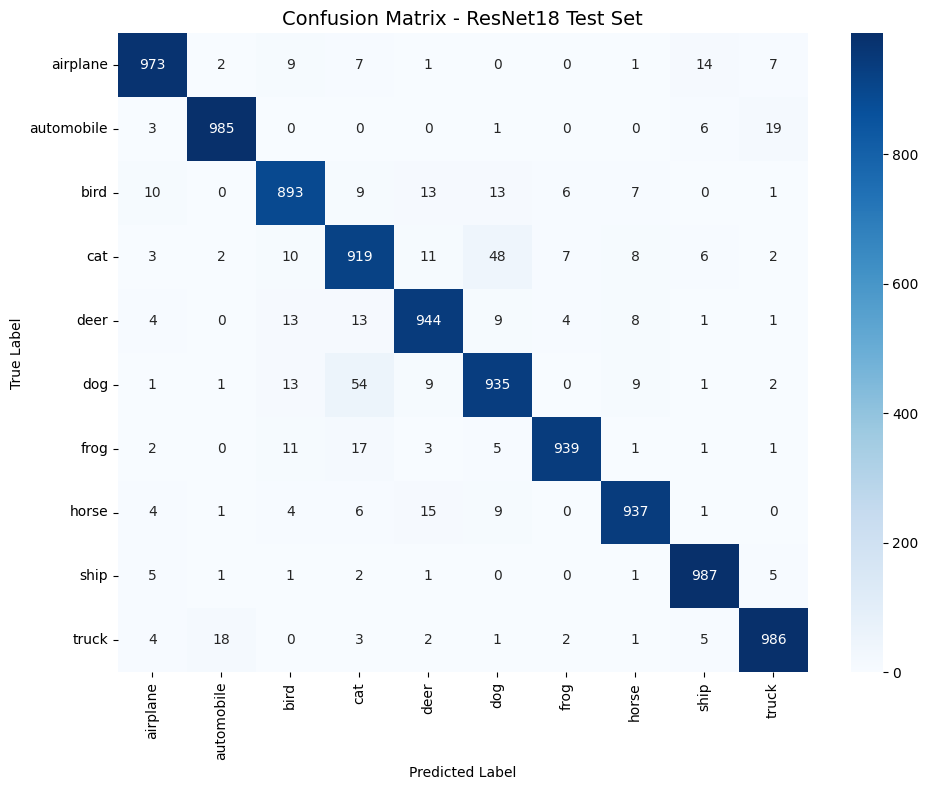


 ResNet18 evaluation complete.

Evaluating EfficientNet-B0 on Test Set


Predicting EfficientNet-B0: 100%|██████████| 79/79 [00:01<00:00, 66.53it/s]



Overall Test Accuracy for EfficientNet-B0: 0.9303 (93.03%)

Classification Report for EfficientNet-B0:

              precision    recall  f1-score   support

    airplane     0.9414    0.9339    0.9376      1014
  automobile     0.9648    0.9724    0.9686      1014
        bird     0.9214    0.9118    0.9166       952
         cat     0.8192    0.8967    0.8562      1016
        deer     0.9450    0.9298    0.9373       997
         dog     0.8960    0.8576    0.8764      1025
        frog     0.9481    0.9510    0.9496       980
       horse     0.9740    0.9212    0.9469       977
        ship     0.9345    0.9811    0.9572      1003
       truck     0.9729    0.9481    0.9604      1022

    accuracy                         0.9303     10000
   macro avg     0.9317    0.9303    0.9307     10000
weighted avg     0.9315    0.9303    0.9305     10000

Saved report: EfficientNet-B0_test_classification_report.csv


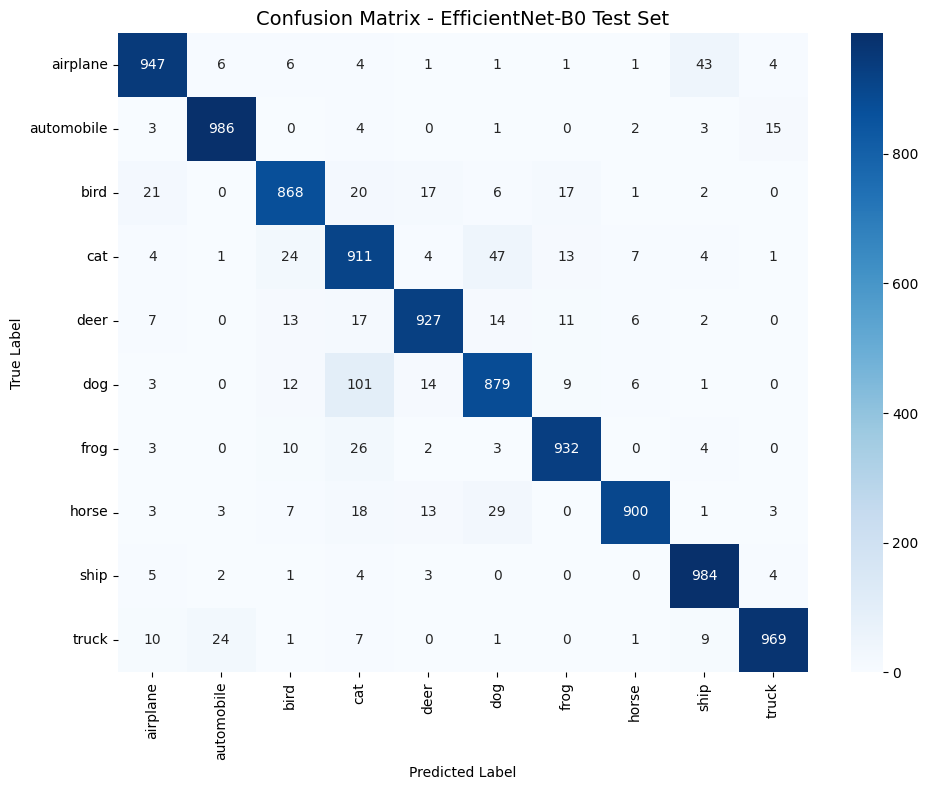


 EfficientNet-B0 evaluation complete.

Evaluating VGG16 on Test Set


Predicting VGG16: 100%|██████████| 79/79 [00:02<00:00, 34.59it/s]



Overall Test Accuracy for VGG16: 0.9692 (96.92%)

Classification Report for VGG16:

              precision    recall  f1-score   support

    airplane     0.9764    0.9773    0.9768      1014
  automobile     0.9862    0.9872    0.9867      1014
        bird     0.9582    0.9622    0.9602       952
         cat     0.9363    0.9262    0.9312      1016
        deer     0.9748    0.9699    0.9723       997
         dog     0.9334    0.9434    0.9384      1025
        frog     0.9846    0.9765    0.9805       980
       horse     0.9746    0.9816    0.9781       977
        ship     0.9812    0.9880    0.9846      1003
       truck     0.9872    0.9804    0.9838      1022

    accuracy                         0.9692     10000
   macro avg     0.9693    0.9693    0.9693     10000
weighted avg     0.9692    0.9692    0.9692     10000

Saved report: VGG16_test_classification_report.csv


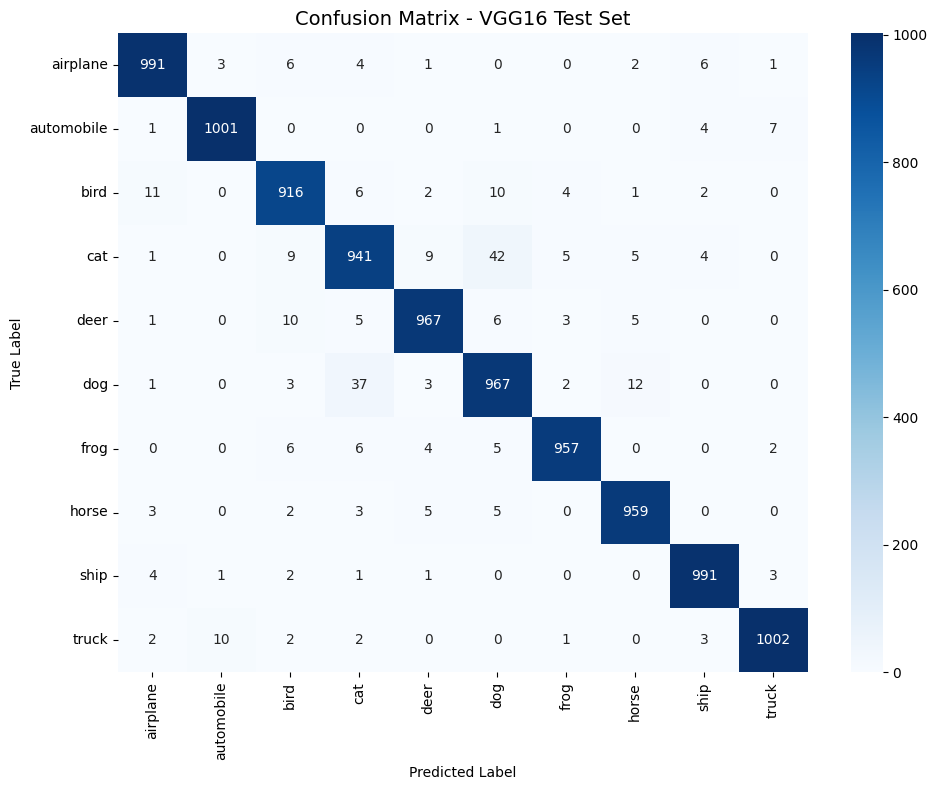


 VGG16 evaluation complete.


In [15]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# Make sure test_label is a numpy array
test_label = np.array(test_label)

# Updated model paths (from Kaggle input directory)
model_info = {
    "ResNet18": "/kaggle/working/model_results/best_ResNet18.pth",
    "EfficientNet-B0": "/kaggle/working/model_results/best_EfficientNet_B0.pth",
    "VGG16": "/kaggle/working/model_results/best_VGG16.pth"
}

# Evaluation Loop
for model_name, best_model_path in model_info.items():
    print("\n" + "="*80)
    print(f"Evaluating {model_name} on Test Set")
    print("="*80)

    # Load model architecture
    if model_name == "ResNet18":
        net = models.resnet18(num_classes=10)
    elif model_name == "EfficientNet-B0":
        net = models.efficientnet_b0(num_classes=10)
    elif model_name == "VGG16":
        net = models.vgg16(num_classes=10)
    else:
        raise ValueError("Unknown model name")

    net = net.to(device)
    net.load_state_dict(torch.load(best_model_path, map_location=device))
    net.eval()

    # --- Inference ---
    all_test_preds = []
    all_test_probs = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Predicting {model_name}"):
            images = batch["img"].to(device)
            outputs = net(images)
            probs = torch.softmax(outputs, dim=1)
            preds = outputs.argmax(1)

            all_test_preds.extend(preds.cpu().numpy())
            all_test_probs.extend(probs.cpu().numpy())

    all_test_preds = np.array(all_test_preds)
    all_test_probs = np.array(all_test_probs)

    # --- Metrics ---
    accuracy = accuracy_score(test_label, all_test_preds)
    print(f"\nOverall Test Accuracy for {model_name}: {accuracy:.4f} ({accuracy*100:.2f}%)")

    report = classification_report(test_label, all_test_preds, target_names=class_names, digits=4)
    print(f"\nClassification Report for {model_name}:\n")
    print(report)

    # Save classification report
    report_dict = classification_report(test_label, all_test_preds, target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()
    report_df.to_csv(f"{model_name}_test_classification_report.csv", index=True)
    print(f"Saved report: {model_name}_test_classification_report.csv")

    # --- Confusion Matrix ---
    cm = confusion_matrix(test_label, all_test_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - {model_name} Test Set", fontsize=14)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.savefig(f"{model_name}_confusion_matrix.png", dpi=300)
    plt.show()

    print(f"\n {model_name} evaluation complete.")